In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import PIL
from sklearn.model_selection import train_test_split
import ast
import shap


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

To begin, import the raw data files that were prepared in the previous Jupyter Notebook.

In [2]:
file_repository = 'C:/Users/roald/Documents/data_science_projects/wine_data'
all_dfs = []

for f in os.listdir(file_repository):
    file_loc = file_repository + '/' + f
    df = pd.read_csv(file_loc, index_col=0)
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
all_dfs.to_csv('wine_review_data.csv')

In [3]:
soil_data = pd.read_csv('soil_data.csv', index_col=0)
weather_data = pd.read_csv('weather_data.csv', index_col=0)
elevation_data = pd.read_csv('elevation_data.csv', index_col=0)
closest_weather_stations= pd.read_csv('closest_weather_stations.csv', index_col=0)
wine_vectors_raw = pd.read_csv('s3://data-science-wine-reviews/wine_review_vectors.csv').set_index('Name')

Now that the raw data files have been loaded, we can merge them together to get our full dataset.

In [4]:
wine_vectors_geo = pd.merge(all_dfs, closest_weather_stations, left_on='Appellation', right_on='Appellation')
wine_vectors_geo = wine_vectors_geo[['Name', 'Appellation', 'Alcohol', 'Variety', 'Vintage', 'Date Published', 'Latitude', 'Longitude', 'Station_ID']]
wine_vectors_alt = pd.merge(wine_vectors_geo, elevation_data, left_on='Appellation', right_on='Appellation', how='inner')
wine_vectors_alt = wine_vectors_alt[['Name', 'Appellation', 'Alcohol', 'Variety', 'Vintage', 'Date Published', 'Latitude', 'Longitude', 'elevation']]
wine_vectors_alt.drop_duplicates(inplace=True)
wine_vectors_weather = pd.merge(wine_vectors_alt, weather_data, 
                                left_on=['Appellation', 'Vintage'], 
                                right_on=['Appellation', 'Vintage'],
                                how='left')
wine_vectors_soil = pd.merge(wine_vectors_weather, soil_data, left_on='Appellation', right_on='appellation', how='left')
wine_vectors_soil.drop('appellation', axis=1, inplace=True)
wine_vectors_soil.head()

,Name,Appellation,Alcohol,Variety,Vintage,Date Published,Latitude,Longitude,elevation,autumn_month_1_prcp,autumn_month_2_prcp,autumn_month_3_prcp,spring_month_1_prcp,spring_month_2_prcp,spring_month_3_prcp,summer_month_1_prcp,summer_month_2_prcp,summer_month_3_prcp,autumn_month_1_tmin,autumn_month_2_tmin,autumn_month_3_tmin,spring_month_1_tmin,spring_month_2_tmin,spring_month_3_tmin,summer_month_1_tmin,summer_month_2_tmin,summer_month_3_tmin,autumn_month_1_tmax,autumn_month_2_tmax,autumn_month_3_tmax,spring_month_1_tmax,spring_month_2_tmax,spring_month_3_tmax,summer_month_1_tmax,summer_month_2_tmax,summer_month_3_tmax,autumn_month_1_avg_tmin,autumn_month_2_avg_tmin,autumn_month_3_avg_tmin,spring_month_1_avg_tmin,spring_month_2_avg_tmin,spring_month_3_avg_tmin,summer_month_1_avg_tmin,summer_month_2_avg_tmin,summer_month_3_avg_tmin,autumn_month_1_avg_tmax,autumn_month_2_avg_tmax,autumn_month_3_avg_tmax,spring_month_1_avg_tmax,spring_month_2_avg_tmax,spring_month_3_avg_tmax,summer_month_1_avg_tmax,summer_month_2_avg_tmax,summer_month_3_avg_tmax,AWCh1_0,AWCh1_30,AWCh1_100,AWCh2_0,AWCh2_30,AWCh2_100,AWCh3_0,AWCh3_30,AWCh3_100,BLDFIE_0,BLDFIE_30,BLDFIE_100,CECSOL_0,CECSOL_30,CECSOL_100,CLYPPT_0,CLYPPT_30,CLYPPT_100,ORCDRC_0,ORCDRC_30,ORCDRC_100,PHIHOX_0,PHIHOX_30,PHIHOX_100,SLTPPT_0,SLTPPT_30,SLTPPT_100,SNDPPT_0,SNDPPT_30,SNDPPT_100,EXBX_0,EXBX_30,EXBX_100,ENAX_0,ENAX_30,ENAX_100,EMGX_0,EMGX_30,EMGX_100,EXKX_0,EXKX_30,EXKX_100,ECAX_0,ECAX_30,ECAX_100,EACKCL_0,EACKCL_30,EACKCL_100,ALUM3S_0,ALUM3S_30,ALUM3S_100,CRFVOL_0,CRFVOL_30,CRFVOL_100,NTO_0,NTO_30,NTO_100,soilmask
0,Michel Rolland Napa Valley 2014 MR Red (Napa V...,"Napa Valley, Napa, California, US",14.9%,Bordeaux-style Red Blend,2014.0,7/1/2019,38.297538,-122.286865,33.43066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,11.0,10.0,10.0,9.0,8.0,9.0,7.0,7.0,1446.0,1525.0,1566.0,27.0,27.0,28.0,30.0,34.0,35.0,29.0,15.0,11.0,74.0,73.0,76.0,34.0,34.0,32.0,35.0,33.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN,NaN,NaN,soil
1,Soquel Vineyards 2015 Intreccio Library Select...,"Napa Valley, Napa, California, US",14.5%,Bordeaux-style Red Blend,2015.0,7/1/2019,38.297538,-122.286865,33.43066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,11.0,10.0,10.0,9.0,8.0,9.0,7.0,7.0,1446.0,1525.0,1566.0,27.0,27.0,28.0,30.0,34.0,35.0,29.0,15.0,11.0,74.0,73.0,76.0,34.0,34.0,32.0,35.0,33.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN,NaN,NaN,soil
2,Flora Springs 2016 Trilogy Red (Napa Valley),"Napa Valley, Napa, California, US",14.2%,Bordeaux-style Red Blend,2016.0,7/1/2019,38.297538,-122.286865,33.43066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,11.0,10.0,10.0,9.0,8.0,9.0,7.0,7.0,1446.0,1525.0,1566.0,27.0,27.0,28.0,30.0,34.0,35.0,29.0,15.0,11.0,74.0,73.0,76.0,34.0,34.0,32.0,35.0,33.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,4.0,NaN,NaN,NaN,soil
3,Michael Pozzan 2015 Marianna Red (Napa Valley),"Napa Valley, Napa, California, US",14.5%,Bordeaux-style Red Blend,2015.0,7/1/2019,38.297538,-122.286865,33.43066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,11.0,10.0,10.0,9.0,8.0,9.0,7.0,7.0,1446.0,1525.0,1566.0,27.0,27.0,28.0,30.0,34.0,35.0,29.0,15.0,11.0,74.0,73.0,76.0,34.0,34.0,32.0,35.0,33.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,

We can add a column for the age of each wine in years. For Southern Hemisphere wines, we will assume that the harvest takes place in mid-April, versus mid-October for Northern Hemisphere wines.

In [5]:
def get_age(vintage, publish_date, latitude):
    if vintage > 1000:
        if latitude < 0:
            production_date_string = str(int(vintage)) + '-04-15'
        else:
            production_date_string = str(int(vintage)) + '-10-15'
        production_date = datetime.datetime.strptime(production_date_string, '%Y-%m-%d')
        publish_date = datetime.datetime.strptime(publish_date, '%m/%d/%Y')
        age = (publish_date - production_date).days/365.25
        if age > 0:
            return age
        else:
            return np.nan
    return np.nan

wine_vectors_soil['age'] = wine_vectors_soil.apply(lambda x: get_age(x['Vintage'], x['Date Published'], x['Latitude']), axis=1)

In [6]:
wine_vectors_soil.describe()

,Vintage,Latitude,Longitude,elevation,autumn_month_1_prcp,autumn_month_2_prcp,autumn_month_3_prcp,spring_month_1_prcp,spring_month_2_prcp,spring_month_3_prcp,summer_month_1_prcp,summer_month_2_prcp,summer_month_3_prcp,autumn_month_1_tmin,autumn_month_2_tmin,autumn_month_3_tmin,spring_month_1_tmin,spring_month_2_tmin,spring_month_3_tmin,summer_month_1_tmin,summer_month_2_tmin,summer_month_3_tmin,autumn_month_1_tmax,autumn_month_2_tmax,autumn_month_3_tmax,spring_month_1_tmax,spring_month_2_tmax,spring_month_3_tmax,summer_month_1_tmax,summer_month_2_tmax,summer_month_3_tmax,autumn_month_1_avg_tmin,autumn_month_2_avg_tmin,autumn_month_3_avg_tmin,spring_month_1_avg_tmin,spring_month_2_avg_tmin,spring_month_3_avg_tmin,summer_month_1_avg_tmin,summer_month_2_avg_tmin,summer_month_3_avg_tmin,autumn_month_1_avg_tmax,autumn_month_2_avg_tmax,autumn_month_3_avg_tmax,spring_month_1_avg_tmax,spring_month_2_avg_tmax,spring_month_3_avg_tmax,summer_month_1_avg_tmax,summer_month_2_avg_tmax,summer_month_3_avg_tmax,AWCh1_0,AWCh1_30,AWCh1_100,AWCh2_0,AWCh2_30,AWCh2_100,AWCh3_0,AWCh3_30,AWCh3_100,BLDFIE_0,BLDFIE_30,BLDFIE_100,CECSOL_0,CECSOL_30,CECSOL_100,CLYPPT_0,CLYPPT_30,CLYPPT_100,ORCDRC_0,ORCDRC_30,ORCDRC_100,PHIHOX_0,PHIHOX_30,PHIHOX_100,SLTPPT_0,SLTPPT_30,SLTPPT_100,SNDPPT_0,SNDPPT_30,SNDPPT_100,EXBX_0,EXBX_30,EXBX_100,ENAX_0,ENAX_30,ENAX_100,EMGX_0,EMGX_30,EMGX_100,EXKX_0,EXKX_30,EXKX_100,ECAX_0,ECAX_30,ECAX_100,EACKCL_0,EACKCL_30,EACKCL_100,ALUM3S_0,ALUM3S_30,ALUM3S_100,CRFVOL_0,CRFVOL_30,CRFVOL_100,NTO_0,NTO_30,NTO_100,age
count,139956.000000,140731.000000,140731.000000,140731.000000,61928.000000,60253.000000,60811.000000,61415.000000,63563.000000,62552.000000,60502.000000,62623.000000,61784.000000,54075.000000,52309.000000,51702.000000,51770.00000,53993.000000,53911.000000,51863.000000,53853.000000,53939.000000,51523.000000,51020.000000,51090.000000,50954.000000,51243.000000,53188.000000,51076.000000,53561.000000,53606.000000,54075.000000,52309.000000,51702.000000,51770.000000,53993.000000,53911.000000,51863.000000,53853.000000,53939.000000,51523.000000,51020.000000,51090.000000,50954.000000,51243.000000,53188.000000,51076.000000,53561.000000,53606.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,135425.000000,137514.000000,137514.000000,137514.000000,135425.000000,135425.000000,135425.000000,137514.000000,137514.000000,137514.000000,137514.000000,137514.000000,137514.000000,137514.000000,137514.000000,137514.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137514.000000,137514.000000,137514.000000,0.0,0.0,0.0,139955.000000
mean,2010.664387,30.633412,-41.952749,365.154253,1.473972,1.415548,1.879813,2.573234,2.319367,2.092662,2.098346,1.980185,1.539815,10.840226,9.860951,6.830978,-1.04315,2.084355,5.091662,4.454193,9.195256,11.146699,34.045415,37.088624,30.243306,22.660767,26.169625,29.246418,28.612987,33.284407,34.202059,15.146707,14.697599,12.057944,4.742220,7.305946,10.304613,9.788607,13.981663,15.439874,27.709241,27.218491,23.607872,15.234614,18.607502,22.006451,21.085719,26.231010,28.015914,15.472697,13.798243,12.335241,12.251431,10.848322,9.607997,10.177057,8.984766,7.936895,1331.761994,1448.280591,1533.796293,23.367222,20.524608,20.257715,24.631063,28.893727,29.710619,61.049777,12.839151,6.551759,71.141120,71.814564,73.661285,39.127129,37.694257,35.677742,46.355782,43.490677,44.705034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.433570,15.615930,16.848394,NaN,NaN,NaN,2.627760
std,4.601701,28.891977,73.586056,356.803855,2.736018,2.233017,3.395150,3.992869,3.497032,2.538229,2.390889,2.977108,3.139190,3.653800,4.305210,4.326587,3.71543,3.371132,3.293730,3.594949,3.131771,3.373977,4.596986,105.559001,9.812307,6.023697,4.136812,4.023349,4.272131,3.973174,4.449345,3.245902,4.495535,3.723803,2.822983,2.646

Since we are studying the impact of terroir on wine, we will eliminate any observations for which we do not have weather data.

We can also drop some of the soil columns that do not contain any data.

Finally, it does seem that there are some strange values for the weather data - temperatures well above 100 and in some cases 1000 degrees. These likely indicate missing values or errors in our dataset.

In [7]:
wine_data = wine_vectors_soil.copy()

empty_soil_cols = ['EXBX_0', 'EXBX_30', 'EXBX_100', 'ENAX_0', 'ENAX_30', 'ENAX_100', 'EMGX_0', 'EMGX_30', 'EMGX_100',
                   'EXKX_0', 'EXKX_30', 'EXKX_100', 'ECAX_0', 'ECAX_30', 'ECAX_100', 'EACKCL_0', 'EACKCL_30', 'EACKCL_100',
                   'ALUM3S_0', 'ALUM3S_30', 'ALUM3S_100', 'NTO_0', 'NTO_30', 'NTO_100', 'soilmask']
wine_data.drop(empty_soil_cols, axis=1, inplace=True)

weather_cols = []
temperature_cols = []
for col in list(wine_data.columns):
    if '_month_' in col:
        weather_cols.append(col)
    if '_tmin' in col or '_tmax' in col:
        temperature_cols.append(col)

wine_data = wine_data.dropna(subset=weather_cols, how='any')
for t in temperature_cols:
    wine_data = wine_data.loc[(wine_data[t] > -70) & (wine_data[t] < 70)]

wine_data.dropna(how='any', inplace=True)
wine_data.head()

,Name,Appellation,Alcohol,Variety,Vintage,Date Published,Latitude,Longitude,elevation,autumn_month_1_prcp,autumn_month_2_prcp,autumn_month_3_prcp,spring_month_1_prcp,spring_month_2_prcp,spring_month_3_prcp,summer_month_1_prcp,summer_month_2_prcp,summer_month_3_prcp,autumn_month_1_tmin,autumn_month_2_tmin,autumn_month_3_tmin,spring_month_1_tmin,spring_month_2_tmin,spring_month_3_tmin,summer_month_1_tmin,summer_month_2_tmin,summer_month_3_tmin,autumn_month_1_tmax,autumn_month_2_tmax,autumn_month_3_tmax,spring_month_1_tmax,spring_month_2_tmax,spring_month_3_tmax,summer_month_1_tmax,summer_month_2_tmax,summer_month_3_tmax,autumn_month_1_avg_tmin,autumn_month_2_avg_tmin,autumn_month_3_avg_tmin,spring_month_1_avg_tmin,spring_month_2_avg_tmin,spring_month_3_avg_tmin,summer_month_1_avg_tmin,summer_month_2_avg_tmin,summer_month_3_avg_tmin,autumn_month_1_avg_tmax,autumn_month_2_avg_tmax,autumn_month_3_avg_tmax,spring_month_1_avg_tmax,spring_month_2_avg_tmax,spring_month_3_avg_tmax,summer_month_1_avg_tmax,summer_month_2_avg_tmax,summer_month_3_avg_tmax,AWCh1_0,AWCh1_30,AWCh1_100,AWCh2_0,AWCh2_30,AWCh2_100,AWCh3_0,AWCh3_30,AWCh3_100,BLDFIE_0,BLDFIE_30,BLDFIE_100,CECSOL_0,CECSOL_30,CECSOL_100,CLYPPT_0,CLYPPT_30,CLYPPT_100,ORCDRC_0,ORCDRC_30,ORCDRC_100,PHIHOX_0,PHIHOX_30,PHIHOX_100,SLTPPT_0,SLTPPT_30,SLTPPT_100,SNDPPT_0,SNDPPT_30,SNDPPT_100,CRFVOL_0,CRFVOL_30,CRFVOL_100,age
13287,Viña Requingua 2015 Potro de Piedra Family Res...,"Curicó Valley, Chile",14%,"Cabernet Sauvignon-Cabernet Franc, Bordeaux-st...",2015.0,7/1/2019,-34.985949,-71.241775,223.36882,0.0,0.536667,0.193103,2.59,0.06,0.8,2.59,0.0,0.0,7.2,2.6,-2.2,0.5,0.7,3.8,0.5,9.2,8.9,33.9,29.2,23.3,22.2,30.5,32.0,22.2,34.4,34.5,11.831034,7.586667,4.289655,7.173333,8.22,8.88,7.173333,12.558065,12.196429,30.5,24.473684,18.209524,18.741667,24.05,26.673333,18.741667,31.716667,31.466667,15.0,13.0,12.0,11.0,10.0,10.0,9.0,8.0,8.0,1433.0,1447.0,1487.0,18.0,21.0,21.0,21.0,27.0,30.0,21.0,14.0,7.0,70.0,70.0,72.0,22.0,22.0,21.0,57.0,52.0,49.0,16.0,18.0,21.0,4.210815
13305,Junta 2015 Gran Reserva Cabernet Franc (Curicó...,"Curicó Valley, Chile",14%,Cabernet Franc,2015.0,12/31/2017,-34.985949,-71.241775,223.36882,0.0,0.536667,0.193103,2.59,0.06,0.8,2.59,0.0,0.0,7.2,2.6,-2.2,0.5,0.7,3.8,0.5,9.2,8.9,33.9,29.2,23.3,22.2,30.5,32.0,22.2,34.4,34.5,11.831034,7.586667,4.289655,7.173333,8.22,8.88,7.173333,12.558065,12.196429,30.5,24.473684,18.209524,18.741667,24.05,26.673333,18.741667,31.716667,31.466667,15.0,13.0,12.0,11.0,10.0,10.0,9.0,8.0,8.0,1433.0,1447.0,1487.0,18.0,21.0,21.0,21.0,27.0,30.0,21.0,14.0,7.0,70.0,70.0,72.0,22.0,22.0,21.0,57.0,52.0,49.0,16.0,18.0,21.0,2.713210
13314,Aresti 2015 Trisquel Gran Reserva Cabernet Sau...,"Curicó Valley, Chile",14.5%,Cabernet Sauvignon,2015.0,6/1/2018,-34.985949,-71.241775,223.36882,0.0,0.536667,0.193103,2.59,0.06,0.8,2.59,0.0,0.0,7.2,2.6,-2.2,0.5,0.7,3.8,0.5,9.2,8.9,33.9,29.2,23.3,22.2,30.5,32.0,22.2,34.4,34.5,11.831034,7.586667,4.289655,7.173333,8.22,8.88,7.173333,12.558065,12.196429,30.5,24.473684,18.209524,18.741667,24.05,26.673333,18.741667,31.716667,31.466667,15.0,13.0,12.0,11.0,10.0,10.0,9.0,8.0,8.0,1433.0,1447.0,1487.0,18.0,21.0,21.0,21.0,27.0,30.0,21.0,14.0,7.0,70.0,70.0,72.0,22.0,22.0,21.0,57.0,52.0,49.0,16.0,18.0,21.0,3.129363
13317,Junta 2015 Momentos Reserva Cabernet Sauvignon...,"Curicó Valley, Chile",13.5%,Cabernet Sauvignon,2015.0,12/31/2017,-34.985949,-71.241775,223.36882,0.0,0.536667,0.193103,2.59,0.06,0.8,2.59,0.0,0.0,7.2,2.6,-2.2,0.5,0.7,3.8,0.5,9.2,8.9,33.9,29.2,23.3,22.2,30.5,32.0,22.2,34.4,34.5,11.831034,7.586667,4.289655,7.173333,8.22,8.88,7.173333,12.558065,12.196429,30.5,24.473684,18.209524,18.741667,24.05,26.673333,18.741667,31.716667,31.466667,15.0,13.0,12.0,11.0,10.0,10.0,9.0,8.0,8.0,1433.0,1447.0,1487.0,18.0,21.0,21.0,21.0,27.0,30.0,21.0,14.0,7.0,70.0,70.0,72.0,22.0,22.0,21.0,57.0,52.0,49.0,16.0,18.0,21.0,2.713210
13318,Echeverria 2015 Reserva Cabernet Sauvignon (Cu...,"Curicó Valley, Chile",13%,Cabernet Sauvignon,2015.0,11/1/2017,-34.9

In [8]:
wine_vector_data = pd.merge(wine_data, wine_vectors_raw, left_on='Name', right_on='Name')
wine_vector_data = wine_vector_data.loc[wine_vector_data['descriptor_count'] >= 5]
wine_vector_data.drop('Unnamed: 0', inplace=True, axis=1)
wine_vector_data.shape

(34203, 92)

In addition to the plethora of terroir-related variables, we also want to include grape varieties in our model. This is important because certain grape varieties only grow in certain geographical areas, leading to a potential dependency between grape variety and terroir.

We will standardize the grape variety names in our dataset, drop any with less than 50 occurences and produce dummy variables for each remaining varietal.

In [9]:
variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio',
                   'Pinot Nero': 'Pinot Noir', 'Pinot Nero, Pinot Noir': 'Pinot Noir', 'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache',
                   'Primitivo': 'Zinfandel', 'Primitivo, Zinfandel': 'Zinfandel', 'Sauvignon, Sauvignon Blanc': 'Sauvignon Blanc',
                  }

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_vector_data['Variety'] = wine_vector_data['Variety'].apply(consolidate_varieties)
variety_value_counts = wine_vector_data['Variety'].value_counts()
variety_value_counts = variety_value_counts.loc[variety_value_counts > 50]
varieties_to_keep = list(variety_value_counts.index)

wine_vector_data_varieties = wine_vector_data.loc[wine_vector_data['Variety'].isin(varieties_to_keep)]
wine_vector_data_dummified = pd.get_dummies(wine_vector_data_varieties, prefix=['variety_'], columns=['Variety'], drop_first=True)

Before we split our dataset into a training and test set, we should address the high dimensionality of our dependent variable - the 300-dimensional wine embeddings. Using PCA, we can compress this dependent variable into a lower-dimensional vector that still captures 75% of the variation of our original embeddings. This reduces the number of dimensions to 53. While this is still a high number, reducing the dimensionality further risks losing essential information contained within the wine embeddings about the flavor profiles of our wines.

In [10]:
wine_vectors = wine_vector_data_dummified['review_vector']

def convert_to_nparray(str_vec):
    str_vec = str(str_vec)
    str_vec = str_vec.replace(r'\n', '').replace('[', '').replace(']', '')
    str_vec_list = str_vec.split(' ')
    str_vec_list = [a.strip() for a in str_vec_list]
    str_vec_list = [a for a in str_vec_list if len(a) > 2]
#     str_vec_array = np.array(str_vec_list)
    return str_vec_list
    
wine_vectors = wine_vectors.apply(convert_to_nparray)
y_df = pd.DataFrame(wine_vectors)

# use PCA to condense our 300-dimensional wine vectors to a single dimension
vals_300 = ['var_' + str(i) for i in range(300)]
y_all_vals = pd.DataFrame(y_df['review_vector'].values.tolist(), columns=vals_300)
pca = PCA(0.7)
principalComponents = pca.fit_transform(y_all_vals)
y_pca_df = pd.DataFrame(principalComponents)

print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

independent_vars = wine_vector_data_dummified.drop(['Name', 'Vintage', 'Appellation', 'Alcohol', 'Date Published', 
                                                    'Latitude', 'Longitude', 'Description', 'descriptors',
                                                    'review_vector', 'descriptor_count'], axis=1)
novar_cols = [v for v in list(independent_vars.columns) if 'variety' not in v]
independent_vars_t = independent_vars[novar_cols]
print(independent_vars.shape)

[0.17609866 0.08915608 0.05567148 0.04157741 0.02402453 0.02084041
 0.01911008 0.0184206  0.01644876 0.01556868 0.01460077 0.01355543
 0.0118946  0.01148819 0.0104485  0.00986349 0.0087773  0.00865722
 0.00836147 0.00790392 0.00751129 0.00742236 0.00730876 0.00684929
 0.0065598  0.00627748 0.00618068 0.00605846 0.00577977 0.00571222
 0.00549154 0.00545112 0.00531473 0.00524074 0.00506638 0.00502469
 0.0048236  0.00473548 0.0046164  0.00457941 0.00454467]
41
(33111, 117)


Next, we will separate our dataset into a training set and a test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(independent_vars, y_pca_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26488, 117) (6623, 117) (26488, 41) (6623, 41)


Now we are ready to build our model! We will use the RandomForestRegressor, which is compatible with multivariate problems such as ours. Trying out a few hyperparameter configurations reveals that a max_depth of 10 yields the best results.

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10, n_estimators=100) 
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

C:\Users\roald\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.3850296098489109


Although our model only has an R-squared value of 36% on the test set, we can still use it to explore which features contribute most towards the predictions that the model makes. We will do this in two ways: first off, we can use the built-in feature importance method in the Random Forest Regressor.

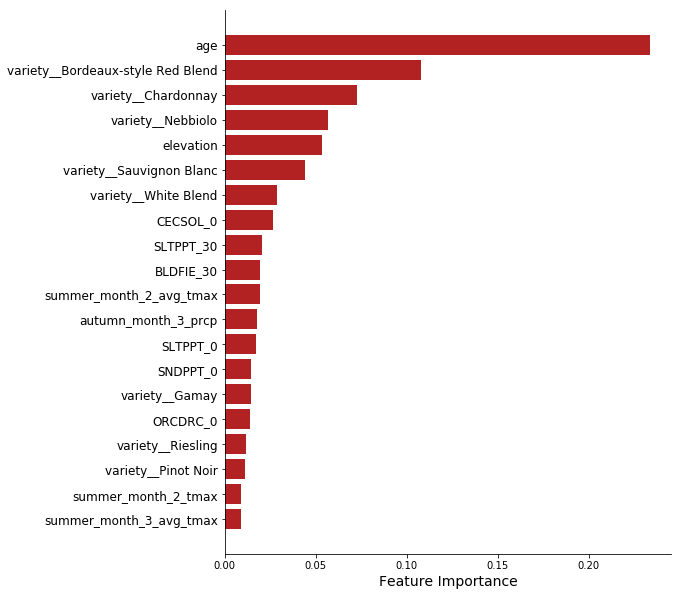

In [24]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
top_features = feature_importances.head(20)

fig, ax = plt.subplots(figsize=(8, 10))

top_feature_names = list(top_features.index)
y_pos = np.arange(len(top_feature_names))
feature_imps = list(top_features['importance'])

ax.barh(y_pos, feature_imps, align='center', color='#b22222')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_feature_names, fontsize=12)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title('', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

We can also examine feature importance using Shapley Values. Shapley Values are a concept from game theory that calculates each feature's marginal contribution to an overall prediction.

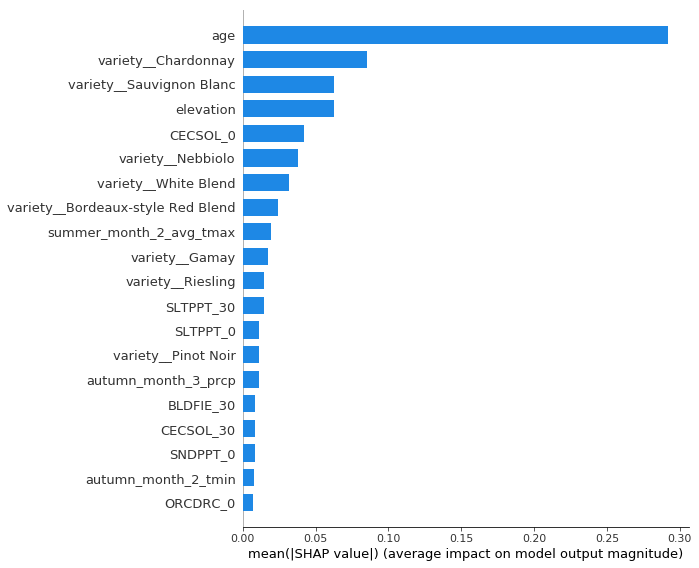

In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", title="Feature Importances Shapley Values")

A couple of variables seem to be most of interest in terms of their impact on the sensory profile of our wines. We will focus on terroir-related characteristics here, in keeping with the theme of this analysis. Across both feature importance calculation methods, elevation, CECSOL_0, autumn_month_3_prcp, summer_2_avg_tmax and SLTPPT_30 appear to be the most significant contributors.

We will examine which descriptors are associated with these terroir variables. To do this for altitude, we can calculate the relative frequency of descriptors in low altitude (bottom quartile) wines vs. high altitude (top quartile) wines. The descriptors with the greatest difference in relative frequency for both categories can be summarized in a wordcloud.

In [15]:
def compare_word_freqs(variable, minval, maxval, label_a, label_b):
    selection_a = wine_vector_data_dummified.loc[wine_vector_data_dummified[variable] <= minval]
    selection_b = wine_vector_data_dummified.loc[wine_vector_data_dummified[variable] >= maxval]
    
    def keyword_list_to_freq(filtered_df):
        filtered_df_keywords = filtered_df['descriptors']
        filtered_df_keywords_list = list(filtered_df_keywords)
        clean_keywords_list = []
        for y in filtered_df_keywords_list:
            list_y = ast.literal_eval(y)
            for word in list_y:
                clean_keywords_list.append(word)
        c = Counter(clean_keywords_list)
        counter_df = pd.DataFrame.from_dict(c, orient='index')
        total_words = counter_df[0].sum()
        counter_df['rel_freq'] = counter_df[0].apply(lambda x: x/total_words)
        counter_df.drop(0, axis=1, inplace=True)
        return counter_df
    
    selection_a_keywords = keyword_list_to_freq(selection_a)
    selection_b_keywords = keyword_list_to_freq(selection_b)
    
    keyword_freq_dfs = pd.merge(selection_a_keywords, selection_b_keywords, left_index=True, right_index=True)
    keyword_freq_dfs.columns = [label_a, label_b]
    return keyword_freq_dfs


def generate_wordcloud(descriptor_dict, mask, color=None, title=None):

    if color is None:
        word_cloud = WordCloud(width=500, height=500, background_color='white', relative_scaling=0.3, mask=mask,
                               colormap='bone').fit_words(descriptor_dict)
    else:
        word_cloud = WordCloud(width=500, height=500, background_color='white', relative_scaling=0.3, mask=mask,
                               color_func=lambda *args, **kwargs: color).fit_words(descriptor_dict)

    plt.imshow(word_cloud, interpolation='bilinear')

    if title:
        plt.title(title, fontsize=48)

    plt.yticks([])
    plt.xticks([])

    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)

        
def initiate_wordcloud(variable, name_low, name_high, color_low, color_high):
    if len(independent_vars[variable].value_counts().index) < 3:
        hi_low = compare_word_freqs(variable, 0, 1, 'low', 'high')
    else:
        hi_low = compare_word_freqs(variable, independent_vars[variable].quantile(0.25), 
                                independent_vars[variable].quantile(0.75), 'low', 'high')
    hi_low['diff'] = hi_low['low'] - hi_low['high']
    hi_low.sort_values(by='diff', inplace=True, ascending=False)
    hi = hi_low.head(10)['diff'].to_dict()
    lo = hi_low.tail(10)['diff'].to_dict()

    mask_circle = np.array(PIL.Image.open("circle.png"))

    fig = plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    generate_wordcloud(lo, mask=mask_circle, color=color_low, title=name_low)
    plt.subplot(1, 2, 2)
    generate_wordcloud(hi, mask=mask_circle, color=color_high, title=name_high)

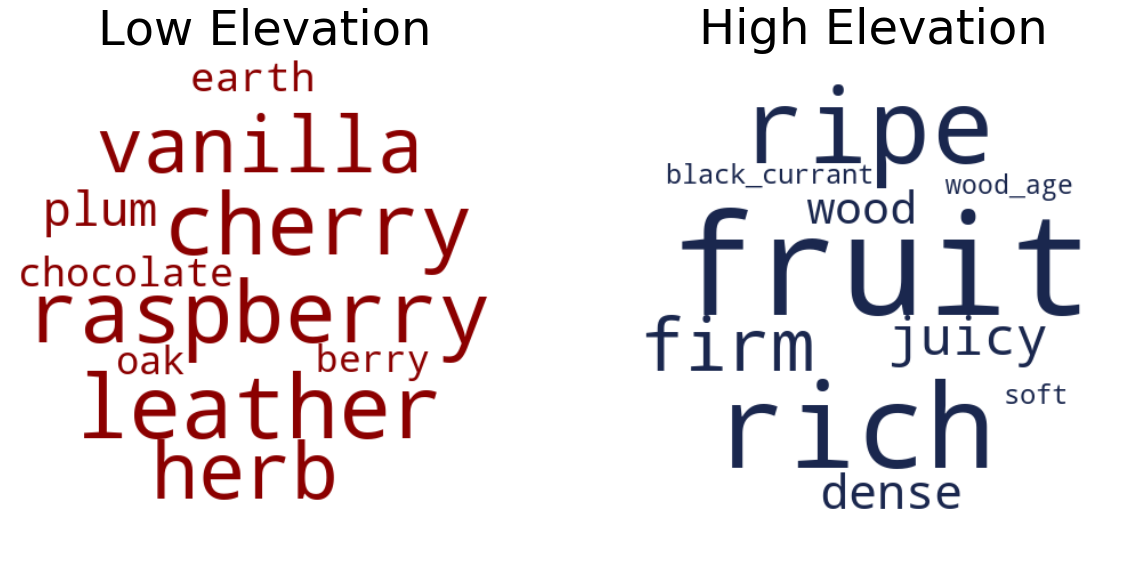

In [16]:
initiate_wordcloud(variable='elevation', name_low='Low Elevation', name_high='High Elevation',
                   color_low='#8B0000', color_high='#1a274e')

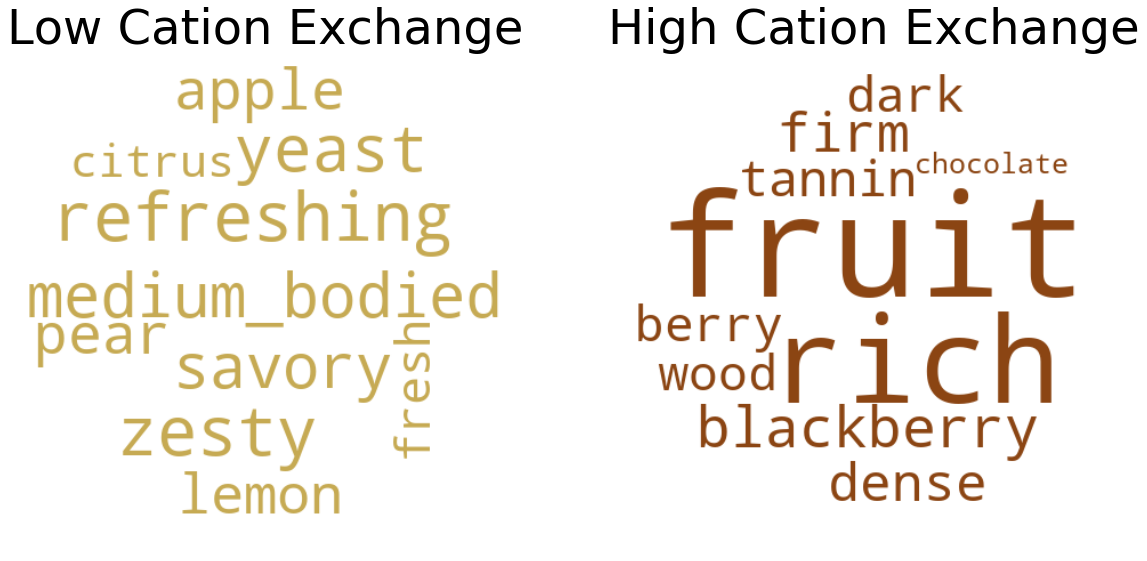

In [17]:
initiate_wordcloud(variable='CECSOL_0', name_low='Low Cation Exchange', name_high='High Cation Exchange',
                   color_low='#c6aa53', color_high='#8b4513')

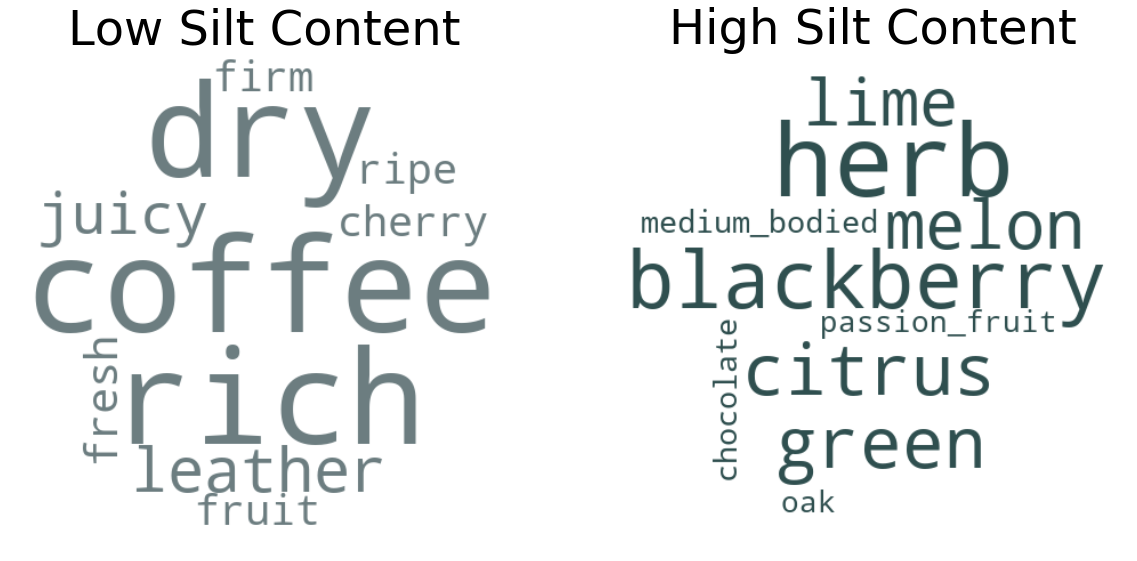

In [18]:
initiate_wordcloud(variable='SLTPPT_30', name_low='Low Silt Content', name_high='High Silt Content',
                   color_low='#6c7d80', color_high='#2f4f4f')

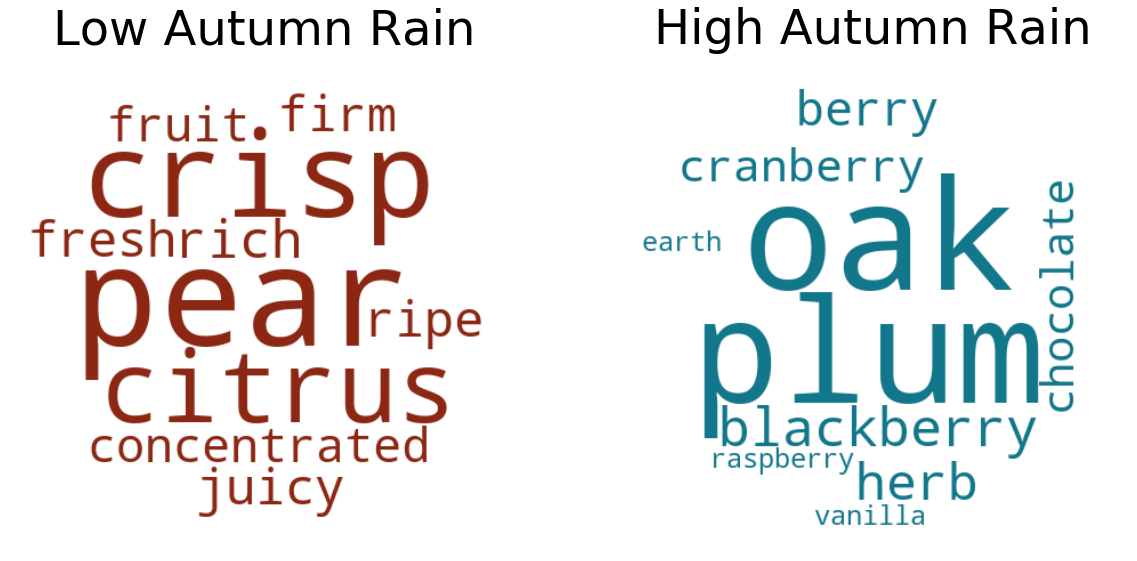

In [19]:
initiate_wordcloud(variable='autumn_month_3_prcp', name_low='Low Autumn Rain', name_high='High Autumn Rain',
                   color_low='#8b2713', color_high='#13778b')

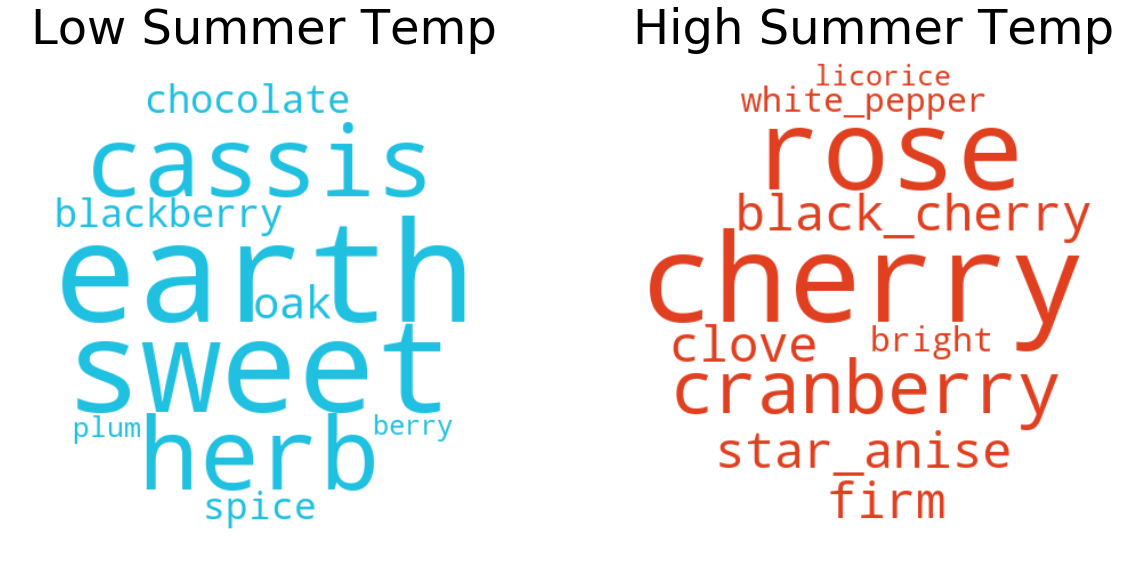

In [20]:
initiate_wordcloud(variable='summer_month_2_avg_tmax', name_low='Low Summer Temp', name_high='High Summer Temp',
                   color_low='#20c0e0', color_high='#e04020')

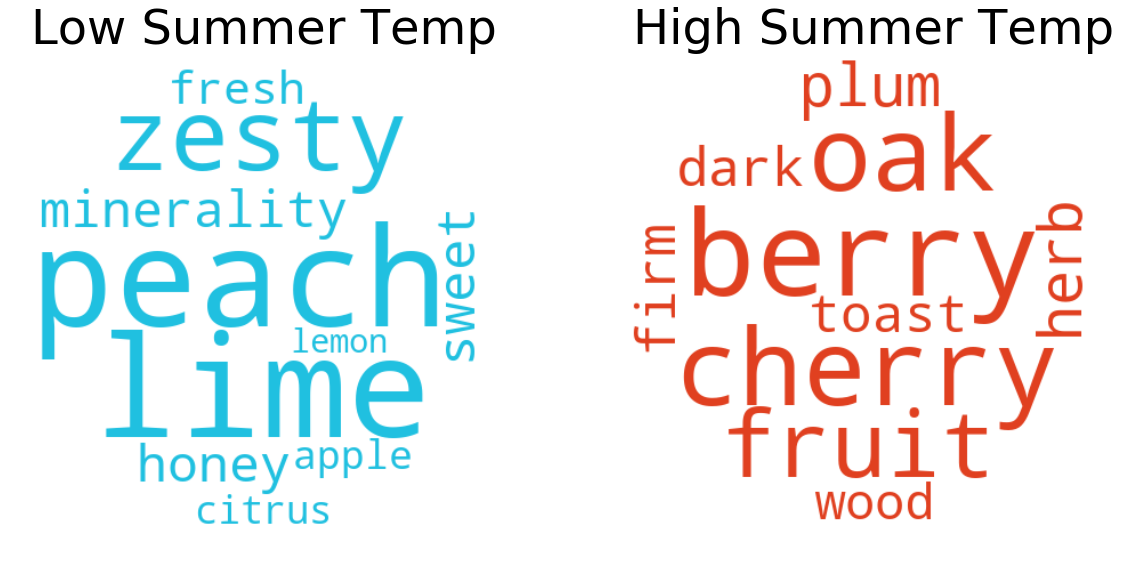

In [21]:
initiate_wordcloud(variable='variety__Riesling', name_low='Low Summer Temp', name_high='High Summer Temp',
                   color_low='#20c0e0', color_high='#e04020')